In [1]:
from textblob.sentiments import PatternAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [2]:
def sentiment_parameters_Pattern(sentence):
    blob = TextBlob(sentence, analyzer=PatternAnalyzer())
    return blob.sentiment.polarity, blob.sentiment.subjectivity

In [3]:
df = pd.read_csv("../Data_Extraction/Reviews/reviews_rating.csv", usecols=['Description','Rating'])

In [4]:
df['score'] = df['Rating'].str.split(' star rating').str.get(0)

In [5]:
score = []
reviews = []
polarity_Pattern = []
subjectivity_Pattern = []

In [6]:
for i in range(df.shape[0]):
    review = df.iloc[i, 0]
    p, s = sentiment_parameters_Pattern(review)
    score.append(float(df.iloc[i, 2]))
    polarity_Pattern.append(p)
    subjectivity_Pattern.append(s)

In [7]:
data_story = {'Review': df['Description'], 'Rating': score, 
              'Polarity_Pattern': polarity_Pattern, 
              'Subjectivity_Pattern': subjectivity_Pattern}
df_story = pd.DataFrame(data_story)

In [8]:
df_story.head()

,Review,Rating,Polarity_Pattern,Subjectivity_Pattern
0,$6.50 for a turmeric matcha seems a bit steep ...,3.0,0.142308,0.411722
1,It's not a far cry to say it's one of my favor...,5.0,0.265385,0.661538
2,"This place is fantastic - for coffee, toast, a...",5.0,0.531685,0.801014
3,Stopped in on our way out of San Fran because ...,4.0,0.288333,0.631667
4,Cute very friendly coffee shop on Divis. I got...,5.0,0.449643,0.675714


In [9]:
df_story.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376 entries, 0 to 1375
Data columns (total 4 columns):
Review                  1376 non-null object
Rating                  1376 non-null float64
Polarity_Pattern        1376 non-null float64
Subjectivity_Pattern    1376 non-null float64
dtypes: float64(3), object(1)
memory usage: 43.1+ KB


/Users/daniela/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


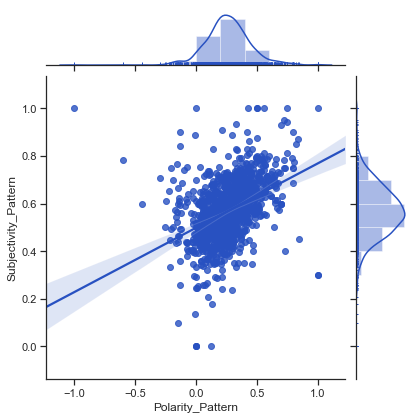

In [10]:
sns.set(style="ticks")

sns.jointplot(x='Polarity_Pattern', y='Subjectivity_Pattern', 
              data=df_story, kind='reg',
              marginal_kws=dict(bins=10, rug=True),
              color='#2851c1')

Questions:

1. There is a strong relationships between polarity and subjectivity data?: check!
2. in that case, this relation is the same that in the subset got by API? Is the info from API representative of the reality?: check!
3. Test law of primacy in persuasion: check!
4. Polarity in yelp reviews and blogs: check!
5. How much affect bad rankings to new people try the store?


3. X2 test of frecuency of topics (use LDA or TFDI?) in process

1. Data story suggested that could have a relation between polarity and subjectivity of reviews. Now, we do a correlation test, using the pearson coefficient and a level of significance of 0.05, using all yelp reviews scrapped. To do so, we permute one variable and fix the another, starting the permutation of the polarity pattern 10000 times.

In [67]:
alpha = 0.05
a, b = np.polyfit(df_story['Polarity_Pattern'], df_story['Subjectivity_Pattern'], 1)

In [68]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)
    # Return entry [0,1]
    return corr_mat[0,1]

In [69]:
p_obs = pearson_r(df_story['Polarity_Pattern'], df_story['Subjectivity_Pattern'])
p_obs

0.41127308127861395

In [70]:
size = 10000
person_replicates = np.empty(size)
for i in range(size):
    polarity_perm = np.random.permutation(df_story['Polarity_Pattern'])
    person_replicates[i] = pearson_r(polarity_perm, df_story['Subjectivity_Pattern'])

In [71]:
p_value = np.sum(person_replicates >= p_obs)/size
p_value

0.0

In [72]:
if p_value >= alpha:
    print('Fail to reject the null hypothesis')
else:
    print('Reject the null hypothesis')

Reject the null hypothesis


We repeat the test permuting the subjectivity coefficients

In [73]:
person_replicates = np.empty(size)
for i in range(size):
    subjectivity_perm = np.random.permutation(df_story['Subjectivity_Pattern'])
    person_replicates[i] = pearson_r(df_story['Polarity_Pattern'], subjectivity_perm)

In [74]:
person_replicates

array([ 0.01552102,  0.03719497, -0.01144009, ...,  0.06035392,
        0.048825  , -0.01992741])

In [75]:
p_value = np.sum(person_replicates >= p_obs)/size
p_value

0.0

In [76]:
if p_value >= alpha:
    print('Fail to reject the null hypothesis')
else:
    print('Reject the null hypothesis')

Reject the null hypothesis


In [77]:
person_replicates = np.empty(size)
for i in range(size):
    subjectivity_perm = np.random.permutation(df_story['Subjectivity_Pattern'])
    polarity_perm = np.random.permutation(df_story['Polarity_Pattern'])
    person_replicates[i] = pearson_r(polarity_perm, subjectivity_perm)

In [78]:
p_value = np.sum(person_replicates >= p_obs)/size
p_value

0.0

In [79]:
if p_value >= alpha:
    print('Fail to reject the null hypothesis')
else:
    print('Reject the null hypothesis')

Reject the null hypothesis


In all case we reject the null hypothesis, that means the relation between the groups could be just a chance, because after 10000 trials, we did not get any pearson coefficient more or equalt to the previous statistic. We have strong evidence to suggest the behavior observed is not statistically significant.

2. Compare data from API and scrapping, and blogs (polarity and subjectity)

In [80]:
df1 = pd.read_csv('../Data_Extraction/Reviews/reviews_yelp_api.csv', usecols=['Name', 'Rating','Description'])

In [84]:
id_coffee = []
coffee_store = []
rating = []
review = []
polarity_Pattern = []
subjectivity_Pattern = []

In [85]:
for i in range(df1.shape[0]):
    data = df1.iloc[i, 2]
    paragrahp = data.split('.')
    paragrahp = [sentence.strip() for sentence in paragrahp]
    for sentence in paragrahp:
        p, s = sentiment_parameters_Pattern(sentence)
        id_coffee.append(i)
        coffee_store.append(df1.iloc[i, 0])
        rating.append(df1.iloc[i, 1])
        review.append(sentence)
        polarity_Pattern.append(p)
        subjectivity_Pattern.append(s)

In [86]:
data_story = {'id': id_coffee, 'Coffee': coffee_store, 'Review': review, 'Rating': rating, 'Polarity_Pattern': polarity_Pattern, 'Subjectivity_Pattern': subjectivity_Pattern}
df1_story = pd.DataFrame(data_story)

In [88]:
df1_story = df1_story[df1_story['Review']!= '']
df1_story['Review'] = [re.sub(r'[^a-zA-Z\s]','', sentence.lower()) for sentence in df1_story['Review']]

In [89]:
df_story_filtered = df1_story[df1_story['Review']!= '']

In [90]:
df_story_filtered.head(10)

,id,Coffee,Review,Rating,Polarity_Pattern,Subjectivity_Pattern
0,0,Four Barrel Coffee,in love with the look and vibes here at four b...,4.0,0.500000,0.600000
1,0,Four Barrel Coffee,big bar for you to order when you walk into th...,4.0,0.000000,0.100000
2,0,Four Barrel Coffee,theres a smaller station off to the side and,4.0,0.000000,0.500000
5,0,Four Barrel Coffee,amazing coffee,4.0,0.600000,0.900000
6,0,Four Barrel Coffee,but so so so freaking busy all the time and re...,4.0,0.133333,0.333333
7,0,Four Barrel Coffee,nnthis place is huge but its so crowded,4.0,0.400000,0.900000
10,0,Four Barrel Coffee,great vibe,4.0,0.800000,0.750000
11,0,Four Barrel Coffee,we love the decor and the environment created ...,4.0,0.500000,0.600000
12,0,Four Barrel Coffee,nncoffee was perfect done with professionalism...,4.0,0.406250,0.750000
16,1,Réveille Coffee Co.,love the vibe in this cozy little space its ch...,4.0,0.066406,0.537500


In [91]:
df_story_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 729
Data columns (total 6 columns):
id                      369 non-null int64
Coffee                  369 non-null object
Review                  369 non-null object
Rating                  369 non-null float64
Polarity_Pattern        369 non-null float64
Subjectivity_Pattern    369 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 20.2+ KB


In [95]:
df_append = result = df_story.append(df_story_filtered, sort=False)

In [96]:
df_append.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 0 to 729
Data columns (total 6 columns):
Review                  1745 non-null object
Rating                  1745 non-null float64
Polarity_Pattern        1745 non-null float64
Subjectivity_Pattern    1745 non-null float64
id                      369 non-null float64
Coffee                  369 non-null object
dtypes: float64(4), object(2)
memory usage: 95.4+ KB


In [101]:
len(df_append['Review'].unique())

1744

In [109]:
size1 = len(df_story_filtered['Polarity_Pattern'])

In [122]:
def bootstrap_replicate_1d(data, size):
    np.random.seed(42)
    return np.random.choice(data, size=size)

In [128]:
#polarity_scrap = bootstrap_replicate_1d(df_story['Polarity_Pattern'], size1)
#pearson_r(polarity_scrap, df_story_filtered['Polarity_Pattern'])

In [140]:
mean_distrib_api = np.mean(df_story_filtered['Polarity_Pattern'])
std_distrib_api = np.std(df_story_filtered['Polarity_Pattern'], ddof=1)

mean_distrib_scrap = np.mean(df_story['Polarity_Pattern'])
std_distrib_scrap = np.std(df_story['Polarity_Pattern'], ddof=1)

print('API source: mean_api=%.3f, std_api=%3f'%(mean_distrib_api, std_distrib_api))
print('Scrapping source: mean_scrapping=%.3f, std_scrapping=%3f'%(mean_distrib_scrap, std_distrib_scrap))

API source: mean_api=0.203, std_api=0.326451
Scrapping source: mean_scrapping=0.265, std_scrapping=0.180920


In [130]:
np.mean(df_story['Polarity_Pattern'])

0.26483949070466606

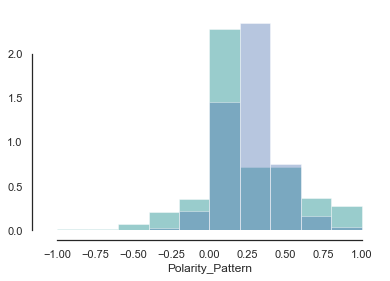

In [170]:
_ = sns.set_style("white")
_ = sns.distplot(df_story_filtered['Polarity_Pattern'], hist=True, kde=False, norm_hist=True, bins=10, color='teal')
_ = sns.distplot(df_story['Polarity_Pattern'], hist=True, kde=False, norm_hist=True, bins=10)
_ = sns.despine(offset=10, trim=True)

In [183]:
polarity_scrap = bootstrap_replicate_1d(df_story['Polarity_Pattern'], size1)
ttest, pval = ttest_rel(polarity_scrap, df_story_filtered['Polarity_Pattern'])

In [184]:
ttest, pval

(3.376546704188567, 0.0008123430475733993)

In [182]:
if pval >= alpha:
    print('Fail to reject the null hypothesis')
else:
    print('Reject the null hypothesis')

Reject the null hypothesis


3. Test law of primacy in persuasion

In [375]:
df_score = df_story[df_story['Review'] != 'None']

In [376]:
df_reviews_score = df_score[['Review','Rating']].reset_index()

In [377]:
df_reviews_score.head()

,index,Review,Rating
0,0,$6.50 for a turmeric matcha seems a bit steep ...,3.0
1,1,It's not a far cry to say it's one of my favor...,5.0
2,2,"This place is fantastic - for coffee, toast, a...",5.0
3,3,Stopped in on our way out of San Fran because ...,4.0
4,4,Cute very friendly coffee shop on Divis. I got...,5.0


In [378]:
n_review, rating, position, subjectivity, polarity, category = [], [], [], [], [], []

for i in range(df_reviews_score.shape[0]):
    paragrahp = df_reviews_score['Review'][i].split('.')[:-1]
    k = 1
    n = i
    for sentence in paragrahp:
        p, s = sentiment_parameters_Pattern(sentence)
        r = df_reviews_score['Rating'][i]
        n_review.append(n)
        rating.append(r)
        position.append(k)
        subjectivity.append(s)
        polarity.append(p)
        threshold = len(paragrahp)/2
        if threshold%2 == 0: #par
            if k <= threshold:
                c = 'A'
            else:
                c = 'B'
        else:
            if k < np.ceil(threshold):
                c = 'A'
            elif k > np.ceil(threshold):
                c = 'B'
            else:
                c = 0
        category.append(c)
        k +=1

In [379]:
data_story2 = pd.DataFrame({'no_review': n_review, 'rating': rating, 
              'position': position, 'subjectivity': subjectivity, 
              'polarity': polarity, 'category': category})

In [380]:
data_story2.set_index('no_review').head()

,rating,position,subjectivity,polarity,category
no_review,,,,,
0,3.0,1,0.0,0.0,A
0,3.0,2,0.0,0.0,A
0,3.0,3,0.0,0.0,A
0,3.0,4,0.0,0.0,A
0,3.0,5,0.0,0.0,0


In [422]:
negative_data = data_story2[data_story2['rating'] < 3]
positive_data = data_story2[data_story2['rating'] > 3]
neutral_data = data_story2[data_story2['rating'] == 3]

In [423]:
n_A = negative_data[negative_data['category'] == 'A']
n_B = negative_data[negative_data['category'] == 'B']

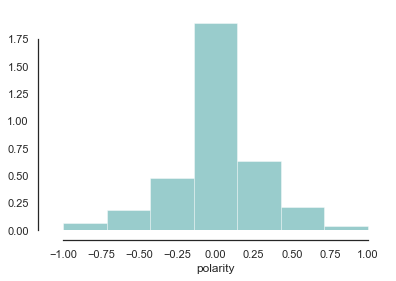

In [424]:
_ = sns.set_style("white")
_ = sns.distplot(n_A['polarity'], hist=True, kde=False, norm_hist=True, bins=7, color='teal')
_ = sns.despine(offset=10, trim=True)

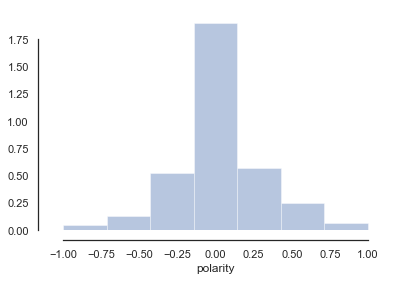

In [425]:
_ = sns.set_style("white")
_ = sns.distplot(n_B['polarity'], hist=True, kde=False, norm_hist=True, bins=7)
_ = sns.despine(offset=10, trim=True)

In [426]:
ttest, pval = ttest_ind(n_A['polarity'], n_B['polarity'])
ttest, pval

(-0.9764470384375223, 0.32915205245079004)

In [427]:
np.mean(n_A['polarity'])

0.003738958043839649

In [428]:
np.mean(n_B['polarity'])

0.024221116534020343

In [429]:
boot_data = bootstrap_replicate_1d(n_A['polarity'], len(n_B['polarity']))
ttest, pval = ttest_rel(boot_data, n_B['polarity'])
ttest, pval

(-0.2139955698610744, 0.8306603757164281)

In [430]:
diff = np.empty(len(n_B['polarity']))

n_B['polarity']-boot_data

p_value = np.sum(n_B['polarity']-boot_data >= 0)/len(n_B['polarity'])

In [431]:
p_value

0.5728643216080402

Fail to reject the null hipothesis of x1-x2> 0, mean(polarity_category_B) > mean(Polarity_category_A)

In [432]:
p_A = positive_data[positive_data['category'] == 'A']
p_B = positive_data[positive_data['category'] == 'B']

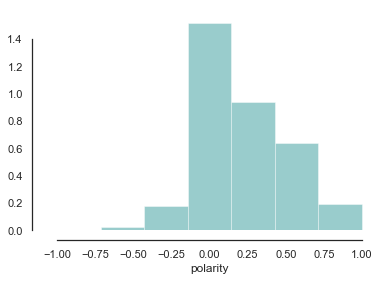

In [433]:
_ = sns.set_style("white")
_ = sns.distplot(p_A['polarity'], hist=True, kde=False, norm_hist=True, bins=7, color='teal')
_ = sns.despine(offset=10, trim=True)

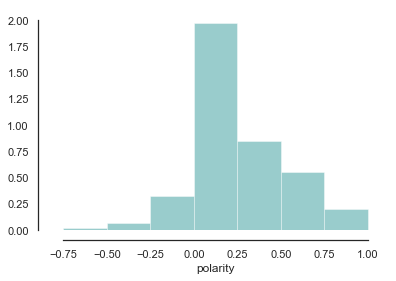

In [434]:
_ = sns.set_style("white")
_ = sns.distplot(p_B['polarity'], hist=True, kde=False, norm_hist=True, bins=7, color='teal')
_ = sns.despine(offset=10, trim=True)

In [435]:
print(np.mean(p_A['polarity']), np.mean(p_B['polarity']))

0.211276416892374 0.2101918509809391


In [444]:
boot_data = bootstrap_replicate_1d(p_A['polarity'], len(p_B['polarity']))
ttest, pval = ttest_rel(boot_data, p_B['polarity'])
ttest, pval

(1.4960565094371119, 0.13472110874159565)

In [445]:
diff = np.empty(len(p_B['polarity']))

p_B['polarity']-boot_data

p_value = np.sum(boot_data - p_B['polarity'] >= 0)/len(p_B['polarity'])

In [446]:
p_value

0.5535016922676387

Not conclusive.

In [439]:
nn_A = neutral_data[neutral_data['category'] == 'A']
nn_B = neutral_data[neutral_data['category'] == 'B']

In [440]:
print(np.mean(nn_A['polarity']), np.mean(nn_B['polarity']))

0.09145420764530328 0.12393242010567963


In [441]:
boot_data = bootstrap_replicate_1d(nn_A['polarity'], len(nn_B['polarity']))
np.mean(boot_data)

0.08530414861012171

In [442]:
diff = np.empty(len(nn_B['polarity']))

p_value = np.sum(nn_B['polarity']-boot_data >= 0)/len(nn_B['polarity'])
p_value

0.6123417721518988

Fail to reject null hypothesis 